In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Test Data

In [3]:
from stockMarket.api import populate_contracts
from stockMarket.core import Contract

ticker = Contract(ticker='GOOG')
test_contracts = populate_contracts(ticker)
contract = test_contracts[0]
contract.revenue

array([307394., 282836., 257637., 182527., 161857., 136819.])

### Retrieve Data

In [2]:
from stockMarket.core import get_tickers_from_index
from stockMarket.api import populate_contracts

tickers = get_tickers_from_index('sp500')
contracts = populate_contracts(tickers)

/home/jag/projects/stockMarket/stockMarket/core/pricing.py:25: UserWarning: No prices available for DOC
  warnings.warn(f"No prices available for {self.ticker}")


### Initialize Ranking

In [6]:
from stockMarket.ranking import Ranking
from stockMarket.ranking.specialRankingObjects import (
    create_equity_ratio_ranker,
    create_netto_margin_ranker,
    create_return_on_assets_ranker,
    create_goodwill_ranker,
    create_gearing_ranker,
    create_dynamic_gearing_ranker,
    create_asset_coverage_ratio_ranker,
    create_third_order_liquidity_ranker,
    create_peg_ranker,
    create_prg_ranker,
    create_pfcg_ranker,
    create_pbg_ranker,
)

years_back = 2

equity_ratio_ranker = create_equity_ratio_ranker([10, 30], [0,1,2])
netto_margin_ranker = create_netto_margin_ranker([10, 20, 30], [0,1,2, 3])
return_on_assets_ranker = create_return_on_assets_ranker([5, 10, 15], [0,1,2,3])
goodwill_ranker = create_goodwill_ranker([0, 30], [0,1,0])
gearing_ranker = create_gearing_ranker([10, 35, 60], [3,2,1,0])
dynamic_gearing_ranker = create_dynamic_gearing_ranker([1, 2, 5], [3,2,1,0])
current_assets_coverage_ratio_ranker = create_asset_coverage_ratio_ranker([100, 130], [0,1,2])
third_order_liquidity_ranker = create_third_order_liquidity_ranker([150, 500], [0,1,2])
peg_ranker_callable = lambda x, y: create_peg_ranker(growth_years=3, cutoffs=[0.5, 1.2], scores=[2,1,0], date=x, years_back=y)
prg_ranker_callable = lambda x, y: create_prg_ranker(growth_years=3, cutoffs=[0.2, 0.4], scores=[2,1,0], date=x, years_back=y)
pfcg_ranker_callable = lambda x, y: create_pfcg_ranker(growth_years=3, cutoffs=[0.6, 1.2], scores=[2,1,0], date=x, years_back=y)
pbg_ranker_callable = lambda x, y: create_pbg_ranker(growth_years=3, cutoffs=[0.4, 1.0], scores=[2,1,0], date=x, years_back=y)

ranking_list = [
    equity_ratio_ranker,
    netto_margin_ranker,
    return_on_assets_ranker,
    goodwill_ranker,
    gearing_ranker,
    dynamic_gearing_ranker,
    current_assets_coverage_ratio_ranker,
    third_order_liquidity_ranker,
    peg_ranker_callable,
    prg_ranker_callable,
    pfcg_ranker_callable,
    pbg_ranker_callable,
]

peg_ranker = peg_ranker_callable(None, years_back)
prg_ranker = prg_ranker_callable(None, years_back)
pfcg_ranker = pfcg_ranker_callable(None, years_back)
pbg_ranker = pbg_ranker_callable(None, years_back)

### Perform Ranking

In [4]:
ranking = Ranking(contracts, ranking_list, years_back=years_back)
ranking.rank()
ranking.ranking.to_csv("ranking_contracts.csv", sep=',', encoding='utf-8', float_format='%.2f')
ranking.ranking

,Name,Sector,Relative Score,Absolute Score,No Data/Constraints/Tot.,Equity Ratio,Equity Ratio Score,Netto Margin,Netto Margin Score,Return on Assets,...,Third Order Liquidity,Third Order Liquidity Score,PEG,PEG Score,PRG,PRG Score,PFCG,PFCG Score,PBG,PBG Score
REGN,"Regeneron Pharmaceuticals, Inc.",Healthcare,95.83%,11.50/12,0*0*12,73.791813,1.0,50.245463,1.000000,31.749021,...,356.386523,0.5,0.266993,1.0,0.182299,1.0,0.272164,1.0,0.191402,1.0
NUE,Nucor Corporation,Basic Materials,87.50%,10.50/12,0*0*12,54.278550,1.0,18.713607,0.333333,26.439383,...,248.177856,0.5,0.024195,1.0,0.024001,1.0,0.107510,1.0,0.186892,1.0
STLD,"Steel Dynamics, Inc.",Basic Materials,87.50%,10.50/12,0*0*12,50.311414,1.0,17.459352,0.333333,25.648440,...,309.828457,0.5,0.055360,1.0,0.029781,1.0,0.281515,1.0,0.142748,1.0
MRNA,"Moderna, Inc.",Healthcare,87.50%,10.50/12,0*1*12,57.339171,1.0,66.060311,1.000000,49.462889,...,176.062664,0.5,-0.008977,0.0,0.007898,1.0,0.025305,1.0,0.029064,1.0
BRK.B,Berkshire Hathaway Inc.,Financial Services,84.85%,9.33/11,1*0*12,51.947650,1.0,31.976388,1.000000,9.956477,...,NaN,0.0,0.000058,1.0,0.002259,1.0,0.006318,1.0,0.000228,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IRM,Iron Mountain Incorporated,Real Estate,2.78%,0.33/12,0*2*12,5.923531,0.0,10.023731,0.333333,3.115696,...,71.400044,0.0,2.342405,0.0,0.884965,0.0,-4.808243,0.0,-27.758548,0.0
MAR,"Marriott International, Inc.",Consumer Cyclical,0.00%,0.00/12,0*3*12,5.533597,0.0,7.931010,0.000000,4.300865,...,56.594350,0.0,-0.181925,0.0,0.406389,0.0,-4.415235,0.0,1.306666,0.0
KVUE,Kenvue Inc.,Consumer Defensive,0.00%,0.00/0,12*0*12,NaN,0.0,NaN,0.000000,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
GEHC,GE HealthCare Technologies Inc.,Healthcare,0.00%,0.00/0,12*0*12,NaN,0.0,NaN,0.000000,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


### Plot Stuff

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

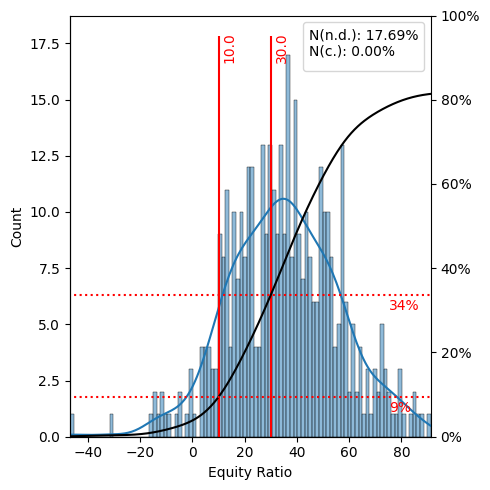

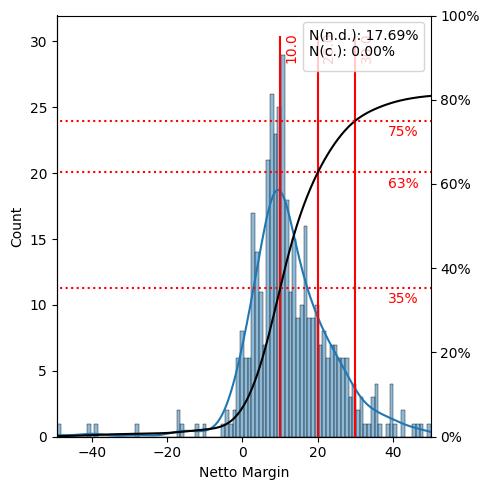

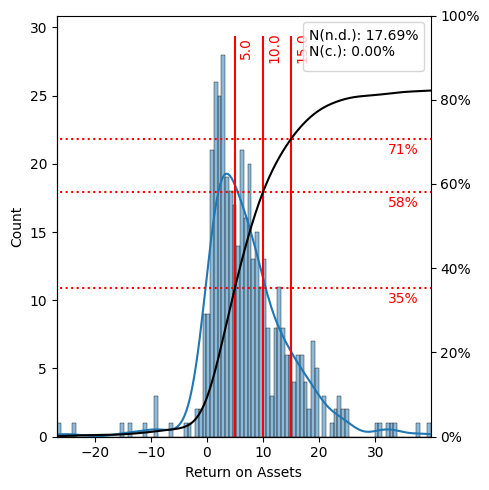

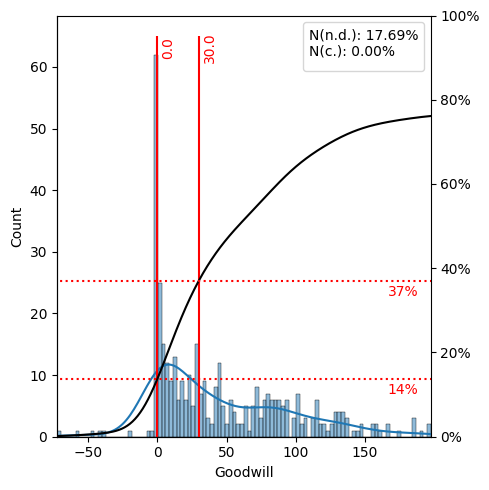

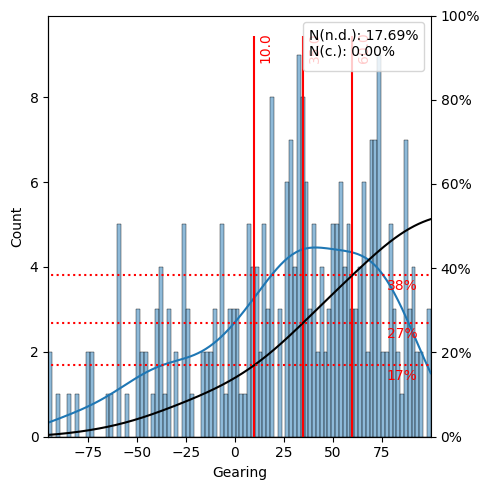

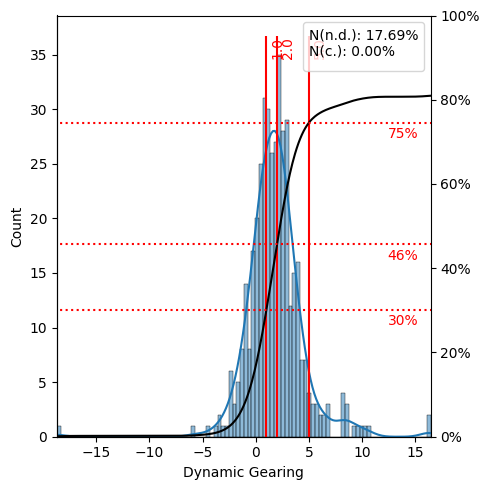

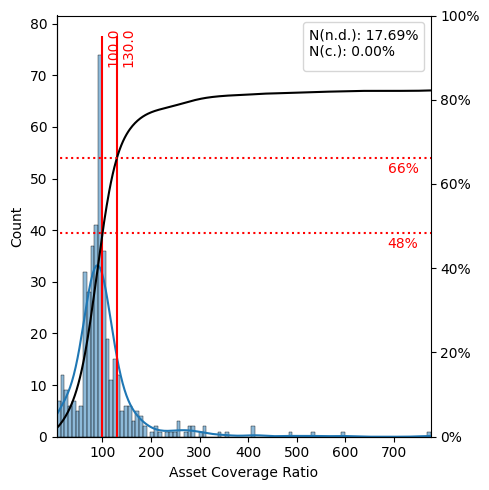

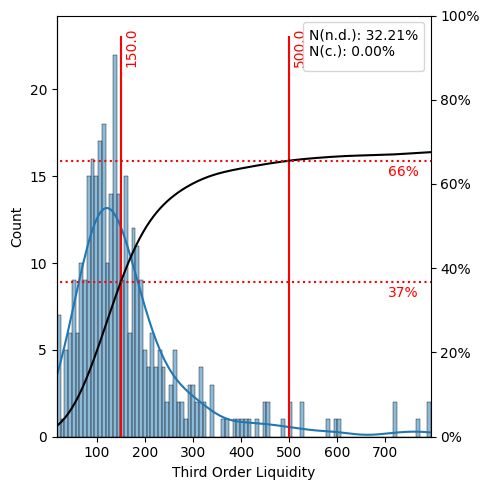

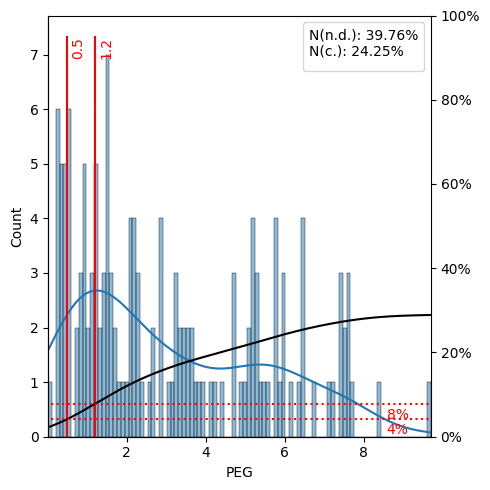

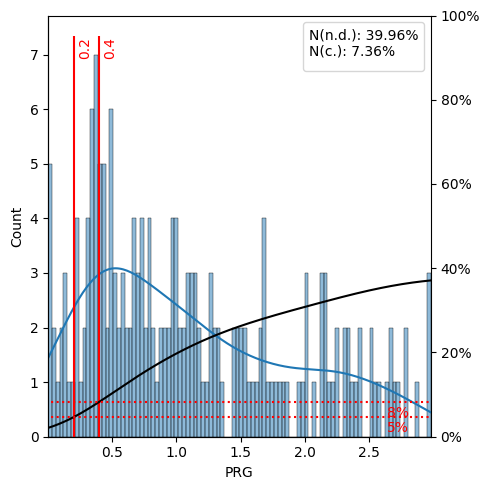

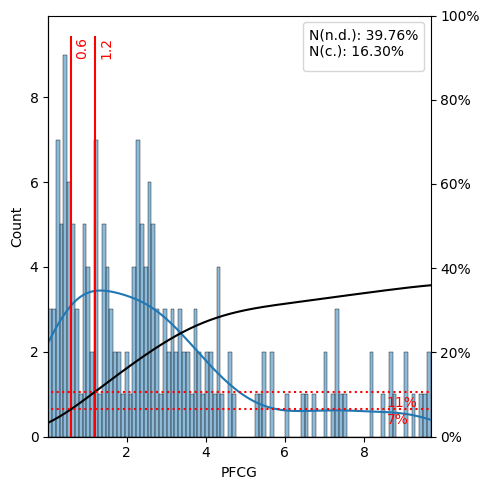

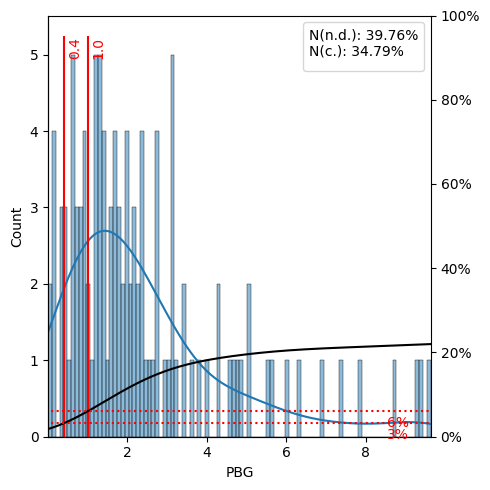

In [7]:
from stockMarket.ranking.rankingPlotter import RankingPlotter

ranking_plotter = RankingPlotter(ranking)
ranking_plotter.plot(equity_ratio_ranker, "equity_ratio.png", (-50, 100))
ranking_plotter.plot(netto_margin_ranker, "netto_margin.png", (-50, 50))
ranking_plotter.plot(return_on_assets_ranker, "return_on_assets.png")
ranking_plotter.plot(goodwill_ranker, "goodwill.png", (-100, 199))
ranking_plotter.plot(gearing_ranker, "gearing.png", (-100, 100))
ranking_plotter.plot(dynamic_gearing_ranker, "dynamic_gearing.png", (-30, 30))
ranking_plotter.plot(current_assets_coverage_ratio_ranker, "current_assets_coverage_ratio.png")
ranking_plotter.plot(third_order_liquidity_ranker, "third_order_liquidity.png", (-1000, 3000))
ranking_plotter.plot(peg_ranker, "peg.png", (0, 10))
ranking_plotter.plot(prg_ranker, "prg.png", (0, 3))
ranking_plotter.plot(pfcg_ranker, "pfcg.png", (0, 10))
ranking_plotter.plot(pbg_ranker, "pbg.png", (0, 10))

plotting_files = [
    "equity_ratio.png",
    "netto_margin.png",
    "return_on_assets.png",
    "goodwill.png",
    "gearing.png",
    "dynamic_gearing.png",
    "current_assets_coverage_ratio.png",
    "third_order_liquidity.png",
    "peg.png",
    "prg.png",
    "pfcg.png",
    "pbg.png"
]

### Backtesting

100%|██████████| 2/2 [00:08<00:00,  4.15s/it]
/home/jag/projects/stockMarket/stockMarket/ranking/backTester/backTester.py:118: RuntimeWarning: Mean of empty slice
  average_performance = np.array(np.nanmean(performance, axis=0))[0]
/home/jag/projects/stockMarket/stockMarket/ranking/backTester/backTester.py:146: RuntimeWarning: Mean of empty slice
  average_performance = np.array(np.nanmean(performance, axis=0))[0]


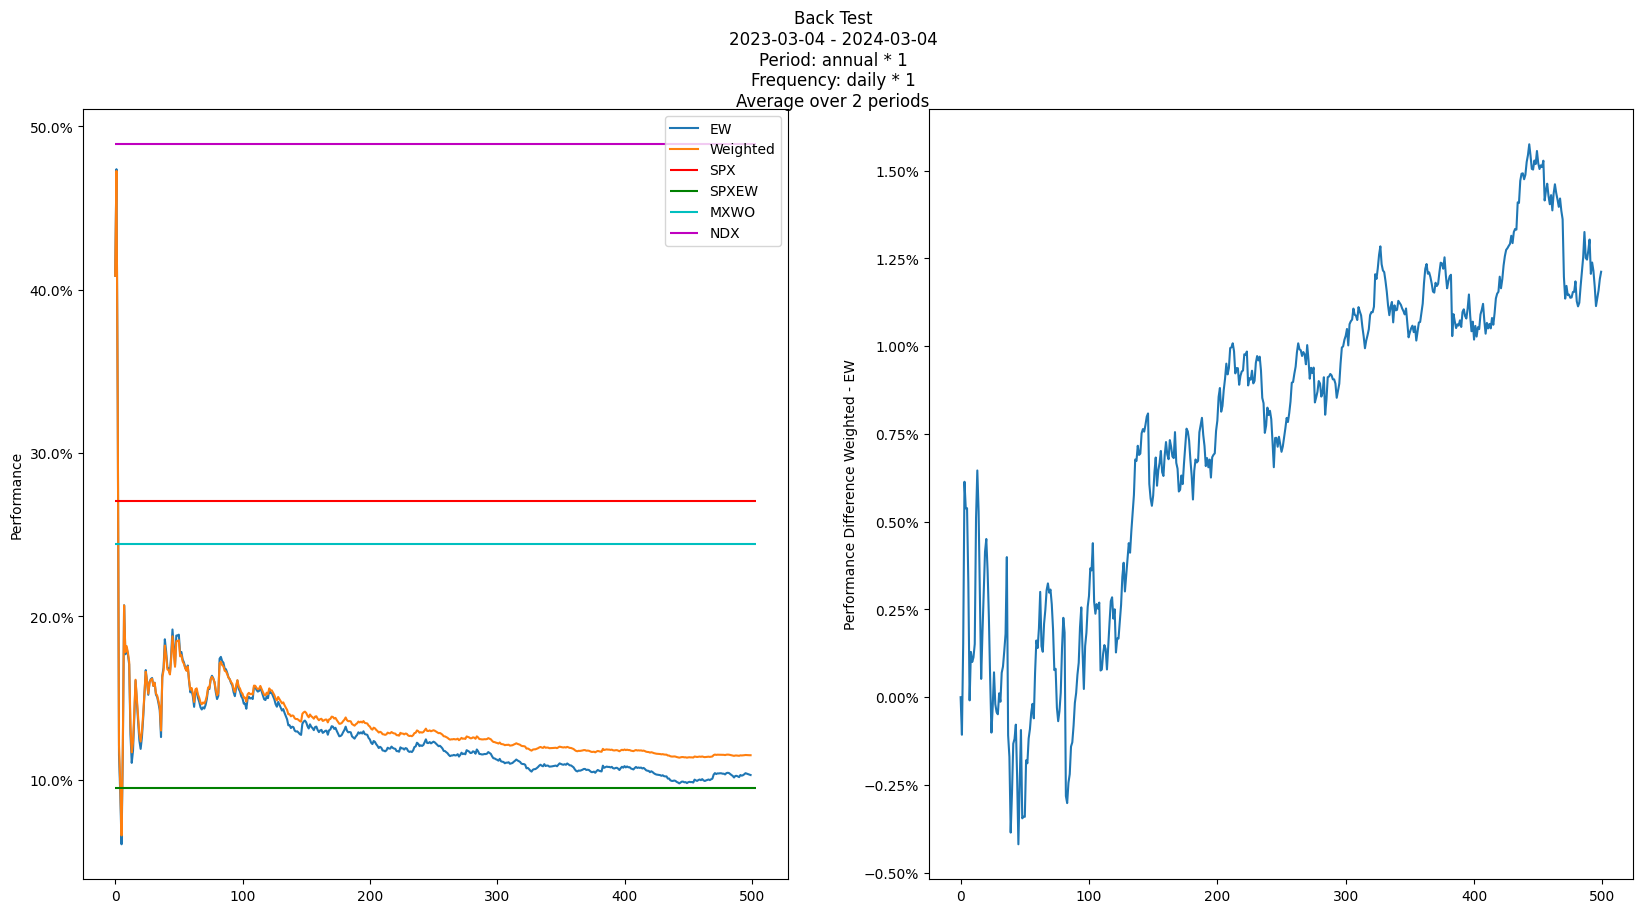

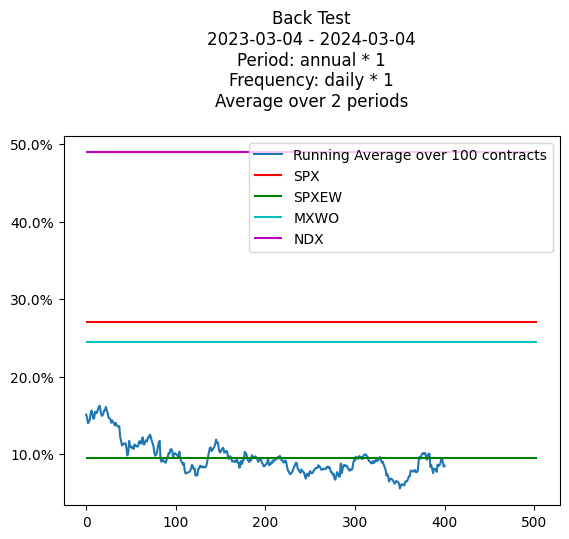

In [9]:
import datetime as dt

from stockMarket.ranking.backTester.backTester import BackTester
from stockMarket.utils.period import Period

back_tester = BackTester(contracts, ranking_list)
start_date = dt.date.today() # - dt.timedelta(days=364*0.5)
end_date = dt.date.today() # - dt.timedelta(days=365)
years_back = 1
# period = Period("monthly", amount=6)
period = Period("annual", amount=1)
frequency = "daily"
back_tester.back_test(date=start_date, end_date=end_date, period=period, frequency=frequency, years_back=years_back)
back_tester.plot_cumulative_performance()
back_tester.plot_single_performances()

In [8]:
back_tester.ranking.ranking
# back_tester.prices

,Name,Sector,Relative Score,Absolute Score,No Data/Constraints/Tot.,Equity Ratio,Equity Ratio Score,Netto Margin,Netto Margin Score,Return on Assets,...,Third Order Liquidity,Third Order Liquidity Score,PEG,PEG Score,PRG,PRG Score,PFCG,PFCG Score,PBG,PBG Score
REGN,"Regeneron Pharmaceuticals, Inc.",Healthcare,91.67%,11.00/12,0*0*12,73.791813,1.0,50.245463,1.000000,31.749021,...,356.386523,0.5,0.308370,1.0,0.218979,0.5,0.363186,1.0,0.217178,1.0
NUE,Nucor Corporation,Basic Materials,87.50%,10.50/12,0*0*12,54.278550,1.0,18.713607,0.333333,26.439383,...,248.177856,0.5,0.157961,1.0,0.076464,1.0,0.173013,1.0,0.264315,1.0
STLD,"Steel Dynamics, Inc.",Basic Materials,87.50%,10.50/12,0*0*12,50.311414,1.0,17.459352,0.333333,25.648440,...,309.828457,0.5,0.194310,1.0,0.065775,1.0,0.268340,1.0,0.184970,1.0
PHM,"PulteGroup, Inc.",Consumer Cyclical,86.36%,9.50/11,1*0*12,53.828111,1.0,12.747631,0.333333,11.526273,...,NaN,0.0,0.414928,1.0,0.213551,0.5,0.373970,1.0,0.217557,1.0
INCY,Incyte Corporation,Healthcare,83.33%,10.00/12,0*0*12,76.418711,1.0,31.764775,1.000000,19.227920,...,365.052651,0.5,0.308616,1.0,0.583434,0.0,0.980014,0.5,0.270500,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AES,The AES Corporation,Utilities,2.78%,0.33/12,0*3*12,8.488305,0.0,-3.671125,0.000000,-1.240785,...,113.186813,0.0,0.201856,0.0,1.719505,0.0,-1.261830,0.0,-1.938783,0.0
MAR,"Marriott International, Inc.",Consumer Cyclical,0.00%,0.00/12,0*4*12,5.533597,0.0,7.931010,0.000000,4.300865,...,56.594350,0.0,-4.852900,0.0,-0.531841,0.0,-2.837716,0.0,-1.227196,0.0
KVUE,Kenvue Inc.,Consumer Defensive,0.00%,0.00/0,12*0*12,NaN,0.0,NaN,0.000000,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
GEHC,GE HealthCare Technologies Inc.,Healthcare,0.00%,0.00/0,12*0*12,NaN,0.0,NaN,0.000000,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


### Write Email

In [12]:
from stockMarket.utils import write_email

emails = ["benjaminlantschner@gmail.com", "97gamjak@gmail.com"]
subject = "Stock Market Ranking"
body = ""
attachment = ["ranking_contracts.csv"] + plotting_files
write_email(emails, subject, body, attachment)